# Convert Keras model into TensorRT model

This notebook will describe the process for converting the saved Keras model into a TensorRT model capable of being deployed in the Jetson Nano GPU.

⚠️ This code is intended to run on the Jetson Nano device or at least on a well-configured GPU device. Running this code on a device without a GPU or with limited GPU capabilities may result in errors during the acceleration process.

## Required imports

In [6]:
import cv2
import time 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants

tensorflow_version = tf.__version__
print(tensorflow_version)

2.4.1


## Optimize for FP16 with TensorRT

In [2]:
SAVED_MODEL_DIR = '../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846'
OUTPUT_SAVED_MODEL_DIR = '../../models/tftrt_cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846'

In [3]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode = trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes = 8000000000,
    )

converter = trt.TrtGraphConverterV2(
   input_saved_model_dir = SAVED_MODEL_DIR, 
   conversion_params = conversion_params
   )

converter.convert()

converter.save(output_saved_model_dir = OUTPUT_SAVED_MODEL_DIR)
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (7, 1, 3)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 3)
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


INFO:tensorflow:Assets written to: ../../models/tftrt_cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/assets


INFO:tensorflow:Assets written to: ../../models/tftrt_cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/assets


Done Converting to TF-TRT FP16


In [4]:
!saved_model_cli show --all --dir "{SAVED_MODEL_DIR}"

2024-03-10 16:21:21.825328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2024-03-10 16:21:42.843086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_25_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 220, 220, 1)
        name: serving_default_conv2d_25_input:0
  The given SavedModel SignatureDef contains the following o

## Test inference time

In [5]:
img_path = '../../utils/090-008-nm-01_1.png'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image/255.0
GEI = tf.reshape(image, [-1,220,220,1])
GEI = tf.dtypes.cast(GEI, tf.float32)

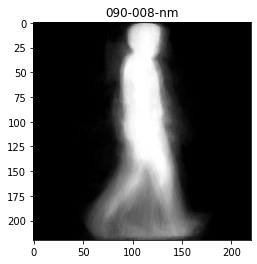

In [8]:
plt.imshow(image, cmap="gray")
plt.title('090-008-nm')
plt.show()

In [9]:
saved_model_loaded = tf.saved_model.load(OUTPUT_SAVED_MODEL_DIR, tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

['serving_default']


In [10]:
infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

{'dense_11': TensorSpec(shape=<unknown>, dtype=tf.float32, name='dense_11')}


In [11]:
model_cnn = tf.keras.models.load_model(SAVED_MODEL_DIR)

In [22]:
start_time = time.time()
pred = model_cnn(GEI)
end_time = time.time()

index = int(tf.argmax(pred, axis=1))
print("Index:", str(index).zfill(3))
print("Prediction:", pred[0][index].numpy())
print("Elapsed Time:", round((end_time-start_time)*1000, 4), "ms")

Index: 008
Prediction: 0.9970837
Elapsed Time: 76.0918 ms


In [21]:
start_time = time.time()
pred = infer(GEI)
end_time = time.time()

index = int(tf.argmax(np.asarray(pred['dense_11']),axis=1))
print("Index:", str(index).zfill(3))
print("Prediction:", np.asarray(pred['dense_11'])[0][index])
print("Elapsed Time:", (end_time-start_time)*1000, "ms")


Index: 008
Prediction: 0.9970837
Elapsed Time: 25.423765182495117 ms
